In [1]:
import numpy as np
import nltk
import nltk.data
from nltk.corpus import wordnet
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from nltk import bigrams
import itertools
import pandas as pd
from nltk import trigrams
from nltk import ngrams
from sklearn.decomposition import TruncatedSVD
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import operator
import seaborn as sb
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import string
import os
from scipy import stats
from scipy.stats import kendalltau, pearsonr
import pickle
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import urllib
from urllib.request import urlretrieve
import zipfile
import lxml
import lxml.etree
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer

# SPAM HAM CLASSIFIER

In [4]:
stop_words = nltk.corpus.stopwords.words('english')
porter = nltk.PorterStemmer()

In [28]:
def preprocess_text(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter.stem(term) 
        for term in cleaned.split()
        if term not in set(stop_words)
    )

In [29]:
df = pd.read_table('data/smsspamcollection/SMSSpamCollection', header=None)
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [30]:
y = df[0]
y.value_counts()

ham     4825
spam     747
Name: 0, dtype: int64

In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [32]:
raw_text = df[1]
labels = df[0]

In [33]:
processed_messages = []

In [35]:
for message in raw_text:
    processed_messages.append(preprocess_text(message))

In [36]:
example = """  ***** CONGRATlations **** You won 2 tIckETs to Hamilton in 
NYC http://www.hamiltonbroadway.com/J?NaIOl/event   wORtH over $500.00...CALL 
555-477-8914 or send message to: hamilton@freetix.com to get ticket !! !  """
preprocess_text(example)

'congratl numbr ticket hamilton nyc httpaddr worth moneysymbnumbr call phonenumbr send messag emailaddr get ticket'

In [37]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(sentences)
X_ngrams.shape

(5572, 36348)

In [95]:
#https://inmachineswetrust.com/posts/sms-spam-filter/#Implementing-the-tf-idf-statistic

In [41]:
from sklearn import svm
from sklearn import *
X_train, X_test, y_train, y_test = train_test_split(
    X_ngrams,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

clf = svm.LinearSVC(loss='hinge')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_test, y_pred)

0.9285714285714286

In [43]:
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index=[['actual', 'actual'], ['spam', 'ham']],
    columns=[['predicted', 'predicted'], ['spam', 'ham']]
)

predicted     
                 spam  ham
actual spam       965    1
       ham         19  130

In [46]:
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit
sample_space = np.linspace(500, len(raw_text) * 0.8, 10, dtype='int')

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=svm.LinearSVC(loss='hinge', C=1e10),
    X=X_ngrams,
    y=y_enc,
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=40),
    scoring='f1',
    n_jobs=-1
)

In [47]:
def make_tidy(sample_space, train_scores, valid_scores):
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='F1 score'
    )

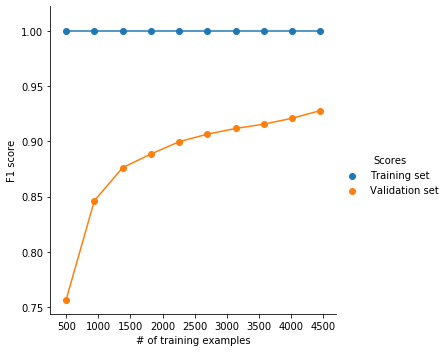

In [49]:
g = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores), hue='Scores', height=5
)

g.map(plt.scatter, '# of training examples', 'F1 score')
g.map(plt.plot, '# of training examples', 'F1 score').add_legend();

In [53]:
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = [{'C': np.logspace(-4, 4, 20)}]

grid_search = GridSearchCV(
    estimator=svm.LinearSVC(loss='hinge'),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    scoring='f1',
    n_jobs=-1
)

scores = cross_val_score(
    estimator=grid_search,
    X=X_ngrams,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    scoring='f1',
    n_jobs=-1
)

scores

array([0.91636364, 0.94366197, 0.95104895, 0.93661972, 0.94736842,
       0.93286219, 0.91039427, 0.90510949, 0.9057971 , 0.94699647])

In [54]:
scores.mean()


0.9296222211583224

In [55]:
grid_search.fit(X_ngrams, y_enc)
final_clf = svm.LinearSVC(loss='hinge', C=grid_search.best_params_['C'])
final_clf.fit(X_ngrams, y_enc);

pd.Series(
    final_clf.coef_.T.ravel(),
    index=vectorizer.get_feature_names()
).sort_values(ascending=False)[:20]

phonenumbr         5.008632
numbrp             2.799188
txt                2.690816
moneysymbnumbr     2.557430
call phonenumbr    2.251018
rington            2.098571
servic             2.049272
mobil              2.036900
numbr              1.896236
tone               1.831284
repli              1.664236
text               1.603975
claim              1.590065
video              1.473553
free               1.359939
wap                1.336547
stop               1.310738
credit             1.278887
uk                 1.239139
order              1.227617
dtype: float64

In [56]:
#https://inmachineswetrust.com/posts/sms-spam-filter/#Implementing-the-tf-idf-statistic
def spam_filter(message):
    if final_clf.predict(vectorizer.transform([preprocess_text(message)])):
        return 'spam'
    else:
        return 'not spam'

# INTENT CLASSIFIER

In [2]:
intent_train = pd.read_csv('data/intent_training.txt', sep='\t', header = None)
print (intent_train)

        0                                                  1
0      No     >>> [1]Contact Me Now to Make $100 Today!$LINK
1      No               Act now to keep your life on the go!
2      No  Choose between $500 and $10000 dollars with up...
3      No                         Click above to earn today.
4      No        Click here to receive your first $10 today:
...   ...                                                ...
3652  Yes  Your Google data archive is ready -- please vi...
3653  Yes  account, or you think you have received this m...
3654  Yes  e-mails, please visit $LINK 111 Durkee Road NE...
3655  Yes  if you have not yet got a chance to review us ...
3656  Yes  kmlemanski please do not share this link with ...

[3657 rows x 2 columns]


In [3]:
intent_test = pd.read_csv('data/intent_test.txt', sep='\t',  header = None)
print(intent_test)

       0                                                  1
0     No  I look forward to meeting you and learning abo...
1     No           We look forward to seeing you next week!
2     No               A quick question before our meeting.
3     No  After sunning and drinking all day we feasted ...
4     No              Also Tuesday, Kyle and Eric 1/2 hour.
..   ...                                                ...
987  Yes  Could you call me on Monday with further infor...
988  Yes     Please call me at your convenience to discuss.
989  Yes  Please call the list around 200 to see if peop...
990  Yes  Please give us a call tomorrow to discuss brie...
991  Yes  Please review the below and lets discuss if th...

[992 rows x 2 columns]


In [4]:
intent_classifier = svm.SVC()

In [5]:
train_labels = intent_train[0]
train_sentences = intent_train[1]

In [6]:
test_labels = intent_test[0]
test_sentences = intent_test[1]

In [7]:
vectorizer = CountVectorizer()
y = vectorizer.fit_transform(train_labels)
X = vectorizer.fit_transform(train_sentences)

In [30]:
train_labels= np.array(train_labels)

In [31]:
intent_classifier.fit(X, train_labels)

C:\Users\Tamara\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [32]:
intent_classifier.predict(X)

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [33]:
intent_classifier.predict(X[3655])

array(['No'], dtype=object)

ValueError: Iterable over raw text documents expected, string object received.

In [27]:
#https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_sentences)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
from sklearn.pipeline import Pipeline
text_clf = Pipeline ([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
text_clf=text_clf.fit(train_sentences, train_labels)
predicted = text_clf.predict(test_sentences)
print(np.mean(predicted == test_labels)) 

from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                    alpha=1e-3, random_state=42)),
                        ])

_ = text_clf_svm.fit(train_sentences, train_labels)
predicted_svm = text_clf_svm.predict(test_sentences)
print(np.mean(predicted_svm == test_labels))


0.7288306451612904
0.8417338709677419


In [18]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),
             }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_sentences, train_labels)

C:\Users\Tamara\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [23]:
print(gs_clf.best_score_)
gs_clf.best_params_

0.712059064807219


{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

In [22]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf-svm__alpha': (1e-2, 1e-3),
                 }
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(train_sentences, train_labels)
print(gs_clf_svm.best_score_)
gs_clf_svm.best_params_

C:\Users\Tamara\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7383100902379


{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [24]:
#https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a